In [1]:
import os
import gc
import re
import abc
import json
import copy
import time
import eli5
import datetime
from numba import jit
from pathlib import Path

from IPython.display import HTML
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
from typing import List, Any

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import random
random.seed(42)
np.random.seed(42)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import lightgbm as lgb

from bayes_opt import BayesianOptimization
import shap

from itertools import product
from functools import partial
from joblib import Parallel, delayed

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import linear_model
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error


# Any results you write to the current directory are saved as output.
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from collections import defaultdict
from joblib import Parallel, delayed

pd.set_option('display.max_columns', 1000)
pd.set_option('max_rows', 500)
pd.options.display.precision = 15
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


# Objective

- 特徴量の追加を行う。
- 具体的には、以下のような特徴量を追加する。

## Notes


    
## Scores
- baseline
    - OOF: 0.5887003970727024
    - Truncated OOF QWK: 0.5489
- GroupK CV, weighted RMSE
    - OOF: 0.5873471117473519
    - Truncated OOF QWK: 0.5574

## Load Data

In [2]:
def read_data(files: list):
    if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
        data_dir_path = '/kaggle/input/data-science-bowl-2019/'
    else:
        data_dir_path = '../data/reduced/'
    
    dst_data = {}
    for file in files:
        print(f'Reading {file} ....')
        dst_data[file] = pd.read_csv(data_dir_path + file)
        print(f'{file} file have {dst_data[file].shape[0]} rows and {dst_data[file].shape[1]} columns.')

    return dst_data.values()


# 'sample_submission.csv', 'specs.csv', 'test.csv', 'train_labels.csv', 'train.csv'
raw_train, raw_test, sample_submission = read_data(['train.csv', 'test.csv', 'sample_submission.csv'])

Reading train.csv ....
train.csv file have 11341042 rows and 11 columns.
Reading test.csv ....
test.csv file have 1156414 rows and 11 columns.
Reading sample_submission.csv ....
sample_submission.csv file have 1000 rows and 2 columns.


In [3]:
print(raw_train.shape)
raw_train.head()

(11341042, 11)


,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


## Creat Feature

In [4]:
# sorted(list(set(raw_train['event_code'].tolist()) & set(raw_test['event_code'].tolist())))
all_event_code = [
    2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 
    3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 
    4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010
]
all_title = [
    '12 Monkeys', 'Air Show', 'All Star Sorting', 'Balancing Act', 'Bird Measurer (Assessment)', 
    'Bottle Filler (Activity)', 'Bubble Bath', 'Bug Measurer (Activity)', 'Cart Balancer (Assessment)', 
    'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)', 'Chicken Balancer (Activity)', 
    'Chow Time', 'Costume Box', 'Crystal Caves - Level 1', 'Crystal Caves - Level 2', 
    'Crystal Caves - Level 3', 'Crystals Rule', 'Dino Dive', 'Dino Drink', 'Egg Dropper (Activity)', 
    'Fireworks (Activity)', 'Flower Waterer (Activity)', 'Happy Camel', 'Heavy, Heavier, Heaviest', 
    'Honey Cake', 'Leaf Leader', 'Lifting Heavy Things', 'Magma Peak - Level 1', 'Magma Peak - Level 2', 
    'Mushroom Sorter (Assessment)', 'Ordering Spheres', 'Pan Balance', "Pirate's Tale", 'Rulers', 
    'Sandcastle Builder (Activity)', 'Scrub-A-Dub', 'Slop Problem', 'Treasure Map', 'Tree Top City - Level 1', 
    'Tree Top City - Level 2', 'Tree Top City - Level 3', 'Watering Hole (Activity)', 'Welcome to Lost Lagoon!'
]
all_type = ['Activity', 'Assessment', 'Clip', 'Game']
all_world = ['CRYSTALCAVES', 'MAGMAPEAK', 'NONE', 'TREETOPCITY']

assessment_title = [
    'Bird Measurer (Assessment)', 'Cart Balancer (Assessment)', 'Cauldron Filler (Assessment)', 
    'Chest Sorter (Assessment)', 'Mushroom Sorter (Assessment)'
]


assessment_title_map = {l: i for i, l in enumerate(assessment_title)}
all_type_map = {l: i for i, l in enumerate(all_type)}
all_world_map = {l: i for i, l in enumerate(all_world)}

In [5]:
class Feature(metaclass=abc.ABCMeta):
    prefix = ""
    suffix = ""
    save_dir = "features"
    is_feature = True

    def __init__(self):
        self.name = self.__class__.__name__
        Path(self.save_dir).mkdir(exist_ok=True, parents=True)
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.categoricals = pd.Series()
        self.train_path = Path(self.save_dir) / f"{self.name}_train.pkl"
        self.test_path = Path(self.save_dir) / f"{self.name}_test.pkl"
        self.categoricals_path = Path(self.save_dir) / f"{self.name}_categoricals.pkl"

    def run(self, train_df, test_df=None, log=False):
        self.create_features(train_df, test_df)
        prefix = self.prefix + "_" if self.prefix else ""
        suffix = self.suffix + "_" if self.suffix else ""
        self.train.columns = pd.Index([str(c) for c in self.train.columns])
        self.test.columns = pd.Index([str(c) for c in self.test.columns])
        self.train.columns = prefix + self.train.columns + suffix
        self.test.columns = prefix + self.test.columns + suffix
        return self

    @abc.abstractmethod
    def create_features(self, train_df, test_df):
        raise NotImplementedError

    def save(self):
        self.train.to_pickle(str(self.train_path))
        self.test.to_pickle(str(self.test_path))
        self.categoricals.to_pickle(str(self.categoricals_path))

In [6]:
"""
## Abbreviations
- sess -> session, game_session
- ins_id -> installation_id
- acc -> accuracy
- pre -> previous
"""
class PastSessSummary(Feature):
    # accuracy_groupの算出
    def cal_accuracy_group(self, accuracy):
        if accuracy == 0:
            return 0
        elif accuracy == 1:
            return 3
        elif accuracy == 0.5:
            return 2
        else:
            return 1
        
    # session単位のデータから特徴量を作成する。
    def get_data(self, ins_id, user_sample, is_test=False):
        all_assessments = []
        # 全過去セッションのcount・sum系特徴量
        past_event_codes = []
        title_count = {i: 0.0 for i in all_title}
        type_count = {i: 0.0 for i in all_type}
        world_count = {i: 0.0 for i in all_world}
        type_sess_time = {i: [] for i in all_type}
        type_event_count = {i: [] for i in all_type}
        # 過去Assessmentの平均・カウントデータ
        past_all_assessments = []        
        acc_group_count = {f'acc_group_cnt_of_{i}': 0 for i in range(4)}
        avg_acc_group = 0
        avg_acc = 0
        avg_num_correct = 0
        avg_num_incorrect = 0
        avg_num_attempt = 0
        # 直前のセッションの特徴量
        pre_title = 'None'
        pre_world = 'None'
        pre_acc_each_title = {f'previous_acc_of_{t}': -1 for t in assessment_title}
        pre_sess_time_title = {f'pre_session_time_of_{title}': -1 for title in all_title}
        pre_sess_time = -1
        # Game セッションの特徴量
        game_sess_keys = [
            'game_num_correct', 'game_num_incorrect', 'game_num_attempt', 'game_accuracy',
            'game_num_event_count', 'game_sess_time', 'game_round', 'game_sum_misses'
        ]
        game_sess_feats = {k: [] for k in game_sess_keys}
        
        game_num_correct = []
        game_num_incorrect = []
        game_num_attempt = []
        game_accuracy = []
        game_num_event_count =[]
        game_sess_time = []
        game_round = []
        game_sum_misses = []

        
        # Parse Session Data
        for n_sess, (game_sess, sess) in enumerate(user_sample.groupby('game_session', sort=False)):
            sess_title = sess['title'].iloc[0]
            sess_type = sess['type'].iloc[0]
            sess_world = sess['world'].iloc[0]
            sess_time = sess['game_time'].iloc[-1]
            sess_event_count = sess['event_count'].iloc[-1]
            event_codes = sess['event_code'].tolist()
            
            # Parse Assessment Session 
            if (sess_type == "Assessment") & (is_test or len(sess)>1):
                attempt_code = 4110 if sess_title == "Bird Measurer (Assessment)" else 4100
                all_attempts = sess.query(f"event_code == {attempt_code}")
                
                num_correct = all_attempts["event_data"].str.contains('"correct":true').sum()
                num_incorrect = all_attempts["event_data"].str.contains('"correct":false').sum()

                num_attempt = num_correct + num_incorrect
                accuracy = round(num_correct / num_attempt, 4) if num_attempt != 0 else 0
                accuracy_group = self.cal_accuracy_group(accuracy)
                # Initialize And Create Features
                features = {}
                features.update({
                    'game_session': game_sess,
                    'installation_id': ins_id,
                    'sess_title': sess_title,
                    'accuracy_group': accuracy_group,
                    'num_past_attemmpt_assessment': len(past_all_assessments),
                    'nunique_past_attemmpt_assessment': len(set(past_all_assessments)),
                    'AVG_acc_group': avg_acc_group,
                    'AVG_acc': avg_acc,
                    'AVG_num_correct': avg_num_correct,
                    'AVG_num_incorrect': avg_num_incorrect,
                    'AVG_num_attempt': avg_num_attempt,
                    'pre_title': sess_title,
                    'pre_world': sess_world,
                    'pre_sess_time': pre_sess_time
                })
                features.update(Counter(past_event_codes))
                features.update(title_count)
                features.update(type_count)
                features.update(world_count)
                features.update(pre_acc_each_title)
                features.update(acc_group_count)
                features.update({f'avg_past_{t}_session_time': np.mean(vals) for t, vals in type_sess_time.items()})
                features.update({f'sum_past_{t}_session_time': np.sum(vals) for t, vals in type_sess_time.items()})
                features.update({f'avg_past_{t}_event_count': np.mean(vals) for t, vals in type_event_count.items()})
                features.update({f'sum_past_{t}_event_count': np.sum(vals) for t, vals in type_event_count.items()})
                features.update(pre_sess_time_title)
                # add game features
                for key, val in game_sess_feats.items():
                    features.update({
                        f'MIN_{key}': np.min(val) if len(val)>0 else 0,
                        f'MAX_{key}': np.max(val) if len(val)>0 else 0,
                        f'AVG_{key}': np.mean(val) if len(val)>0 else 0,
                        f'STD_{key}': np.std(val) if len(val)>0 else 0,
                        f'SUM_{key}': np.sum(val) if len(val)>0 else 0
                    })
                
                if is_test:
                    all_assessments.append(features)
                elif num_attempt > 0:
                    all_assessments.append(features)
                
                # --------------------------------------------------------------------------------
                # Assessment特徴量の更新
                past_all_assessments.append(sess_title)
                pre_acc_each_title[f'previous_acc_of_{sess_title}'] = accuracy
                acc_group_count[f'acc_group_cnt_of_{accuracy_group}'] += 1
                avg_acc_group = (avg_acc_group + accuracy_group) / n_sess if n_sess!=0 else 0
                avg_acc = (avg_acc + accuracy) / n_sess if n_sess!=0 else 0
                avg_num_correct = (avg_num_correct + num_correct) / n_sess if n_sess!=0 else 0
                avg_num_incorrect = (avg_num_incorrect + num_incorrect) / n_sess if n_sess!=0 else 0
                avg_num_attempt = (avg_num_attempt + num_attempt) / n_sess if n_sess!=0 else 0
                
            if sess_type=='Game':
                g_num_correct = sess['event_data'].str.contains('"correct":true').astype(int).sum()
                g_num_incorrect = sess['event_data'].str.contains('"correct":false').astype(int).sum()
                g_num_attempt = g_num_correct + g_num_incorrect
                g_accuracy = g_num_correct / g_num_attempt if g_num_attempt!=0 else -1
                g_round = sess[sess['event_data'].str.contains('round')]['event_data'].str.extract('."round":(\w).').max()[0]
                g_misses = sess[sess['event_data'].str.contains('round')]['event_data'].str.extract('."misses":(\w).').sum()
                g_misses = g_misses[0] if len(g_misses)>0 else 0
                
                game_sess_feats['game_num_correct'].append(g_num_correct)
                game_sess_feats['game_num_incorrect'].append(g_num_incorrect)
                game_sess_feats['game_num_attempt'].append(g_num_attempt)
                game_sess_feats['game_accuracy'].append(g_accuracy)
                game_sess_feats['game_num_event_count'].append(len(event_codes))
                game_sess_feats['game_sess_time'].append(sess_time)
                game_sess_feats['game_round'].append(g_round)
                game_sess_feats['game_sum_misses'].append(g_misses)
            
                    
            # All Session Feature
            past_event_codes.extend(event_codes)
            title_count[sess_title] += 1
            type_count[sess_type] += 1
            world_count[sess_world] += 1
            type_sess_time[sess_type].append(sess_time)
            type_event_count[sess_type].append(sess_event_count)
            pre_title = sess_title
            pre_world = sess_world
            pre_sess_time_title[sess_title] = sess_time
            pre_sess_time = sess_time
    
        return all_assessments
        
    
    # installation_idでgroupbyする役割を持ちデータをclass変数に割り当てる。
    def create_features(self, train, test):
        compiled_train = []
        compiled_test = []
        
        for ins_id, user_sample in tqdm(train.groupby('installation_id', sort=False)):
            compiled_train += self.get_data(ins_id, user_sample)
        
        for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False)):
            compiled_test += self.get_data(ins_id, user_sample, is_test=True)
        
        train = pd.DataFrame(compiled_train)
        test = pd.DataFrame(compiled_test) 

        categoricals = ['sess_title', 'pre_title', 'pre_world']
        for c in categoricals:
            unique_val = list( set(train[c].tolist()) | set(test[c].tolist()) )
            le = LabelEncoder().fit(unique_val)
            train[c] = le.transform(train[c])
            test[c] = le.transform(test[c])
        
        self.train = train
        self.test = test
        self.categoricals = pd.Series(categoricals)

In [7]:
%%time
PastSessSummary().run(raw_train, raw_test).save()


CPU times: user 7min 58s, sys: 8.87 s, total: 8min 7s
Wall time: 8min 31s


## Feature Selection

In [25]:
# Load Feature
reduced_train = pd.read_pickle('./features/PastSessSummary_train.pkl')
reduced_test = pd.read_pickle('./features/PastSessSummary_test.pkl').drop_duplicates(subset='installation_id', keep='last')
categoricals = pd.read_pickle('./features/PastSessSummary_categoricals.pkl').tolist()

In [26]:
print('train_size: ', reduced_train.shape)
print('test_size: ', reduced_test.shape)
reduced_train.head()

train_size:  (17690, 217)
test_size:  (1000, 217)


,game_session,installation_id,sess_title,accuracy_group,num_past_attemmpt_assessment,nunique_past_attemmpt_assessment,AVG_acc_group,AVG_acc,AVG_num_correct,AVG_num_incorrect,AVG_num_attempt,pre_title,pre_world,pre_sess_time,2000,3010,4070,3110,4030,4021,4020,4090,4010,2080,2081,2020,2040,2030,3021,3121,2050,3020,3120,2083,2025,4035,4025,4022,12 Monkeys,Air Show,All Star Sorting,Balancing Act,Bird Measurer (Assessment),Bottle Filler (Activity),Bubble Bath,Bug Measurer (Activity),Cart Balancer (Assessment),Cauldron Filler (Assessment),Chest Sorter (Assessment),Chicken Balancer (Activity),Chow Time,Costume Box,Crystal Caves - Level 1,Crystal Caves - Level 2,Crystal Caves - Level 3,Crystals Rule,Dino Dive,Dino Drink,Egg Dropper (Activity),Fireworks (Activity),Flower Waterer (Activity),Happy Camel,"Heavy, Heavier, Heaviest",Honey Cake,Leaf Leader,Lifting Heavy Things,Magma Peak - Level 1,Magma Peak - Level 2,Mushroom Sorter (Assessment),Ordering Spheres,Pan Balance,Pirate's Tale,Rulers,Sandcastle Builder (Activity),Scrub-A-Dub,Slop Problem,Treasure Map,Tree Top City - Level 1,Tree Top City - Level 2,Tree Top City - Level 3,Watering Hole (Activity),Welcome to Lost Lagoon!,Activity,Assessment,Clip,Game,CRYSTALCAVES,MAGMAPEAK,NONE,TREETOPCITY,previous_acc_of_Bird Measurer (Assessment),previous_acc_of_Cart Balancer (Assessment),previous_acc_of_Cauldron Filler (Assessment),previous_acc_of_Chest Sorter (Assessment),previous_acc_of_Mushroom Sorter (Assessment),acc_group_cnt_of_0,acc_group_cnt_of_1,acc_group_cnt_of_2,acc_group_cnt_of_3,avg_past_Activity_session_time,avg_past_Assessment_session_time,avg_past_Clip_session_time,avg_past_Game_session_time,sum_past_Activity_session_time,sum_past_Assessment_session_time,sum_past_Clip_session_time,sum_past_Game_session_time,avg_past_Activity_event_count,avg_past_Assessment_event_count,avg_past_Clip_event_count,avg_past_Game_event_count,sum_past_Activity_event_count,sum_past_Assessment_event_count,sum_past_Clip_event_count,sum_past_Game_event_count,pre_session_time_of_12 Monkeys,pre_session_time_of_Air Show,pre_session_time_of_All Star Sorting,pre_session_time_of_Balancing Act,pre_session_time_of_Bird Measurer (Assessment),pre_session_time_of_Bottle Filler (Activity),pre_session_time_of_Bubble Bath,pre_session_time_of_Bug Measurer (Activity),pre_session_time_of_Cart Balancer (Assessment),pre_session_time_of_Cauldron Filler (Assessment),pre_session_time_of_Chest Sorter (Assessment),pre_session_time_of_Chicken Balancer (Activity),pre_session_time_of_Chow Time,pre_session_time_of_Costume Box,pre_session_time_of_Crystal Caves - Level 1,pre_session_time_of_Crystal Caves - Level 2,pre_session_time_of_Crystal Caves - Level 3,pre_session_time_of_Crystals Rule,pre_session_time_of_Dino Dive,pre_session_time_of_Dino Drink,pre_session_time_of_Egg Dropper (Activity),pre_session_time_of_Fireworks (Activity),pre_session_time_of_Flower Waterer (Activity),pre_session_time_of_Happy Camel,"pre_session_time_of_Heavy, Heavier, Heaviest",pre_session_time_of_Honey Cake,pre_session_time_of_Leaf Leader,pre_session_time_of_Lifting Heavy Things,pre_session_time_of_Magma Peak - Level 1,pre_session_time_of_Magma Peak - Level 2,pre_session_time_of_Mushroom Sorter (Assessment),pre_session_time_of_Ordering Spheres,pre_session_time_of_Pan Balance,pre_session_time_of_Pirate's Tale,pre_session_time_of_Rulers,pre_session_time_of_Sandcastle Builder (Activity),pre_session_time_of_Scrub-A-Dub,pre_session_time_of_Slop Problem,pre_session_time_of_Treasure Map,pre_session_time_of_Tree Top City - Level 1,pre_session_time_of_Tree Top City - Level 2,pre_session_time_of_Tree Top City - Level 3,pre_session_time_of_Watering Hole (Activity),pre_session_time_of_Welcome to Lost Lagoon!,MIN_game_num_correct,MAX_game_num_correct,AVG_game_num_correct,STD_game_num_correct,SUM_game_num_correct,MIN_game_num_incorrect,MAX_game_num_incorrect,AVG_game_num_incorrect,STD_game_num_incorrect,SUM_game_num_incorrect,MIN_game_num_attempt,MAX_game_num_attempt,AVG_

In [27]:
# Rename Columns For LightGBM
reduced_train.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduced_train.columns]
reduced_test.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in reduced_test.columns]

In [28]:
# Define Feature
features = reduced_train.loc[(reduced_train.sum(axis=1) != 0), (reduced_train.sum(axis=0) != 0)].columns
features = [x for x in features 
            if x not in [
                'game_session', 'installation_id', 'num_correct', 'num_incorrect', 'accuracy_group',
                'accuracy', 'game_time']
           ]


# Reduce Feature
to_remove = []
to_exclude = []


# Drop High Correlation
def get_high_corr(df, features, verbose=False):
    drop_cols = []
    counter = 0
    for feat_a in features:
        for feat_b in features:
            if feat_a != feat_b and feat_a not in drop_cols and feat_b not in drop_cols:
                corr = np.corrcoef(df[feat_a], df[feat_b])[0][1]
                if corr > 0.995:
                    counter += 1
                    drop_cols.append(feat_b)
                    if verbose:
                        print(f'{counter}: {feat_a} {feat_b} - Correlation: {corr}')
    return drop_cols

to_remove += get_high_corr(reduced_train, features)



# Manual Reduced Feature

## Null importance
## https://qiita.com/KenkenGoda/items/1d6ede5d492d1a9dc3c9
## https://www.kaggle.com/ogrellier/feature-selection-with-null-importances


# Remove Feature
categoricals = [x for x in categoricals if x not in (to_exclude + to_remove)]
features = [x for x in features if x not in (to_exclude + to_remove)]

## Training Model

In [29]:
from numba import jit 

@jit
def qwk3(a1, a2, num_class=4):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((num_class, ))
    hist2 = np.zeros((num_class, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(num_class):
        for j in range(num_class):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]
    return 1 - o / e

In [30]:
class OptimizedRounder(object):
    def __init__(self, num_class=4):
        self.coef_ = 0
        self.initial_coef = [i for i in np.arange(1, (num_class+1)/2, 0.5)]
        self.labels = [i for i in range(num_class)]
    
    def _kappa_loss(self, coef, X, y):
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=self.labels)
        return -qwk3(y, preds)
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = self.initial_coef
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')
    
    def predict(self, X):
        coef = self.coefficients()
        preds = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels=self.labels)
        return preds
    
    def coefficients(self):
        return self.coef_['x']

In [31]:
def lgb_reg_qwk(y_pred:np.ndarray, data:lgb.Dataset):
    y_true = data.get_label()

    OptR = OptimizedRounder(num_class=4)
    OptR.fit(y_pred, y_true)
    y_pred = OptR.predict(y_pred).astype(int)
    # name, result, is_higher_better
    return "qwk", qwk3(y_true, y_pred), True


def lgb_regression_rmse(y_pred:np.ndarray, data:lgb.Dataset):
    y_true = data.get_label()
    return "rmse", np.sqrt(mean_squared_error(y_true, y_pred)), False

def lgb_weighted_rmse(y_pred:np.ndarray, data:lgb.Dataset):
    y_true = data.get_label()
    weight = data.get_weight()
    return "rmse", np.sqrt(mean_squared_error(y_true, y_pred, sample_weight=weight)), False

In [32]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], 
                 n_splits=5, cv_method='StratifiedKFold', verbose=True, ps={}, custom_eval=None, weight=None):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'accuracy_group'
        self.groups = 'installation_id'
        self.cv = self.get_cv(cv_method)
        self.verbose = verbose
        self.params = self.set_params(ps)
        self.custom_eval = custom_eval
        self.weight = weight
        self.oof_pred, self.y_pred, self.score, self.models = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self, cv_method):
        method = cv_method
        if method=='StratifiedKFold':
            cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
            return cv.split(self.train_df, self.train_df[self.target])
        elif method=='GroupKFold':
            cv = GroupKFold(n_splits=self.n_splits)
            return cv.split(self.train_df, self.train_df[self.target], self.train_df[self.groups])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        models = []
        
        for fold, (train_idx, valid_idx) in enumerate(self.cv):
            x_train, y_train = self.train_df[self.features].iloc[train_idx], self.train_df[self.target][train_idx]
            x_valid, y_valid = self.train_df[self.features].iloc[valid_idx], self.train_df[self.target][valid_idx]
            
            train_set, valid_set = self.convert_dataset(x_train, y_train, x_valid, y_valid)
            
            # additonal process, Weight validation data only
            if self.weight is not None:
                valid_set = self.set_weights(valid_set, self.weight[valid_idx])
                
            model = self.train_model(train_set, valid_set)
            models.append(model)
            
            conv_x_val = self.convert_x(x_valid)
            oof_pred[valid_idx] = model.predict(conv_x_val).reshape(oof_pred[valid_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print(f'Partial score of fold {fold} is: {qwk3(y_valid, oof_pred[valid_idx])}\n')
            
        loss_score = qwk3(self.train_df[self.target], oof_pred)
        if self.verbose:
            print(f'\nOur oof cohen kappa score is: {loss_score}\n')
            
        return oof_pred, y_pred, loss_score, models

In [33]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity, feval=self.custom_eval)
        
    def convert_dataset(self, x_train, y_train, x_valid, y_valid):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        valid_set = lgb.Dataset(x_valid, y_valid, categorical_feature=self.categoricals)
        return train_set, valid_set
    
    def set_weights(self, data, weight):
        return data.set_weight(weight)
        
    def get_params(self):
        params = {
            'n_estimators':5000,
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'subsample': 0.75,
            'subsample_freq': 1,
            'learning_rate': 0.03,
            'feature_fraction': 0.8,
            'max_depth': 7,
            'num_leaves': 2**4,
            'min_data_in_leaf': 50,
            'lambda_l1': 1,  
            'lambda_l2': 1,
            "n_jobs": -1,
            'early_stopping_rounds': 100
        }
        return params
                                                                        
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params    
    
    def get_feature_importance(self, models):
        feature_importance = pd.DataFrame(
            [model.feature_importance() for model in models],
            columns=models[0].feature_name()
        ).T

        feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
        feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
        feature_importance.sort_values(by='Agerage_Importance', inplace=True)
        return feature_importance
    
    def plot_importance(self, models, max_num_features=50, figsize=(12, 15)):
        feature_importance = self.get_feature_importance(models)
        plt.figure(figsize=figsize)
        
        feature_importance[-max_num_features:].plot(
            kind='barh', title='Feature importance', figsize=figsize,
            y='Agerage_Importance', xerr='importance_std',
            grid=True, align="center"
        )
        plt.legend()
        plt.show()

In [34]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    lgb_model = Lgb_Model(reduce_train, ajusted_test, features, categoricals=categoricals,ps=params)
    print('kappa: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 3),
    'learning_rate': (0.025, 0.4),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (1, 5),
    'lambda_l2': (1, 5),
    'max_depth': (15, 17),
}

params={}

if False and os.path.exists('/kaggle/input/data-science-bowl-2019/'):
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
        
    params = LGB_BO.max['params']
    print('\n', LGB_BO.max['params'])

In [35]:
# GroupK CV, optimized QWK
# lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params, 
#                       cv_method='GroupKFold', custom_eval=lgb_reg_qwk)

# GroupK CV, weighted rmse
weight = (1 / (reduced_train.groupby('installation_id')['game_session'].transform('nunique')+1)).values
lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params, 
                      cv_method='GroupKFold', custom_eval=lgb_weighted_rmse, weight=weight)

# lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params,
#                       custom_eval=lgb_reg_qwk)
# lgb_model = Lgb_Model(reduced_train, reduced_test, features, categoricals=categoricals, ps=params, custom_eval=lgb_reg_qwk, weights=weights)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.97579	training's rmse: 0.97579	valid_1's rmse: 1.05035	valid_1's rmse: 1.05035
[200]	training's rmse: 0.93743	training's rmse: 0.93743	valid_1's rmse: 1.04112	valid_1's rmse: 1.04112
[300]	training's rmse: 0.911445	training's rmse: 0.911445	valid_1's rmse: 1.03969	valid_1's rmse: 1.03969
[400]	training's rmse: 0.889597	training's rmse: 0.889597	valid_1's rmse: 1.03837	valid_1's rmse: 1.03837
[500]	training's rmse: 0.869282	training's rmse: 0.869282	valid_1's rmse: 1.03803	valid_1's rmse: 1.03803
Early stopping, best iteration is:
[433]	training's rmse: 0.88265	training's rmse: 0.88265	valid_1's rmse: 1.03741	valid_1's rmse: 1.03741
Partial score of fold 0 is: 0.48111746203448236

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.974016	training's rmse: 0.974016	valid_1's rmse: 1.02995	valid_1's rmse: 1.02995
[200]	training's rmse: 0.936868	training's rmse: 0.93686

<Figure size 864x2016 with 0 Axes>

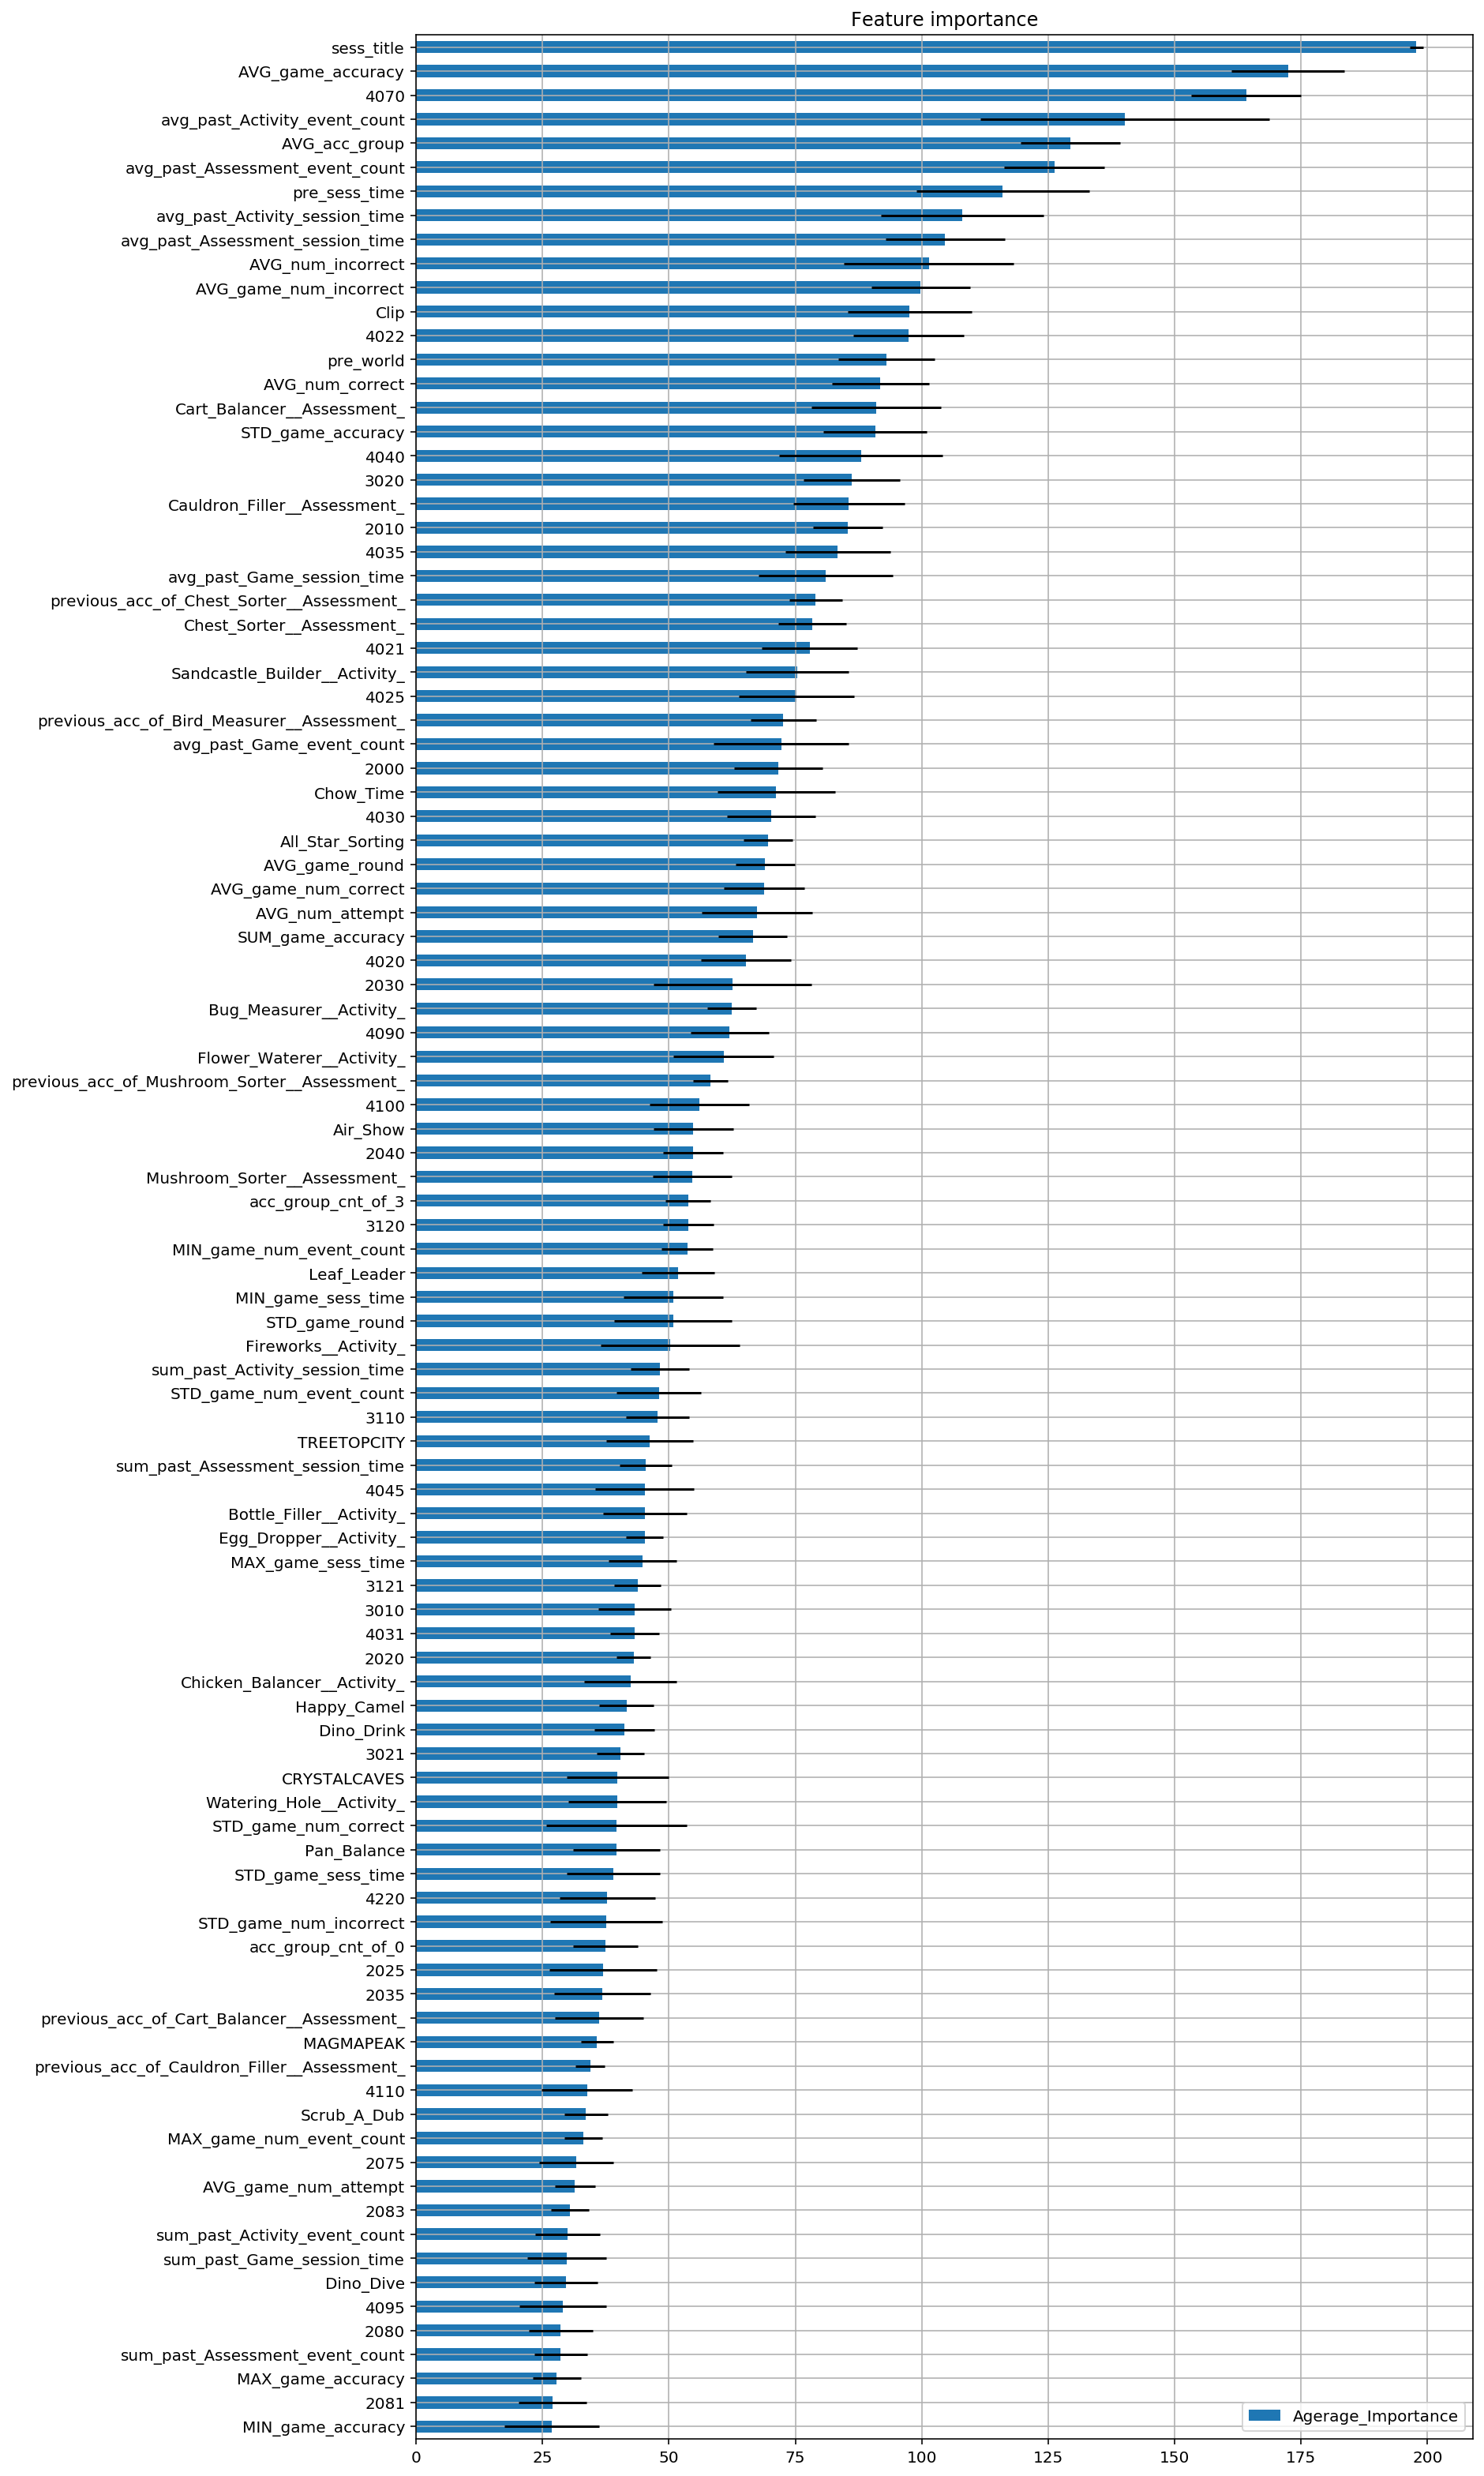

In [36]:
lgb_model.plot_importance(lgb_model.models, max_num_features=100, figsize=(12, 28))

## Model Evaluation

In [37]:
final_pred = lgb_model.y_pred
trian_pred = lgb_model.oof_pred

optR = OptimizedRounder(num_class=4)
optR.fit(trian_pred, reduced_train['accuracy_group'])
opt_preds = optR.predict(trian_pred)

sub_preds = optR.predict(final_pred)

print(final_pred.shape)

(1000,)


In [38]:
rmse_score = np.sqrt(mean_squared_error(reduced_train['accuracy_group'], lgb_model.oof_pred))
print(f'RMSE: {rmse_score}\n')

off_score = qwk3(reduced_train['accuracy_group'], opt_preds)
print(f'OOF: {off_score}\n')

print(f'coefficients: {optR.coefficients()}\n')

RMSE: 0.9966571152007563

OOF: 0.5873471117473519

coefficients: [1.03354742 1.48243971 2.2623475 ]



In [39]:
def eval_with_truncated_data(y_pred, y_true, groups, n_trials=10):
    eval_result = {}
    trials = []
    gp_idx_df = pd.DataFrame({"groups": groups, "index": np.arange(len(y_pred))})
    
    dice_results = []
    for _, df in gp_idx_df.groupby("groups"):
        dice_result = np.random.choice(df["index"], size=n_trials)
        dice_results.append(dice_result)

    idx_choice = np.vstack(dice_results)
    for i in range(n_trials):
        y_pred_choice = y_pred[idx_choice[:, i]]
        y_true_choice = y_true[idx_choice[:, i]]
        trials.append(qwk3(y_true_choice, y_pred_choice))

    mean_score = np.mean(trials)
    median_score = np.median(trials)
    std = np.std(trials)
    eval_result["mean"] = mean_score
    eval_result["median"] = median_score
    eval_result["all_trials"] = trials
    eval_result["0.95lower_bound"] = mean_score - 2 * std
    eval_result["0.95upper_bound"] = mean_score + 2 * std
    eval_result["std"] = std
    return eval_result

truncated_score = eval_with_truncated_data(opt_preds, reduced_train['accuracy_group'], reduced_train['installation_id'])

print(f"Truncated OOF QWK: {truncated_score['mean']:.4f}")
print(f"Truncated OOF QWK median: {truncated_score['median']:.4f}")
print(f"Truncated OOF QWK 0.95 upper: {truncated_score['0.95upper_bound']:.4f}")
print(f"Truncated OOF QWK 0.95 lower: {truncated_score['0.95lower_bound']:.4f}")
print(f"Truncated OOF QWK std: {truncated_score['std']:.4f}")

Truncated OOF QWK: 0.5505
Truncated OOF QWK median: 0.5492
Truncated OOF QWK 0.95 upper: 0.5630
Truncated OOF QWK 0.95 lower: 0.5381
Truncated OOF QWK std: 0.0062


OOF: 0.5873471117473519
Truncated OOF QWK: 0.5505


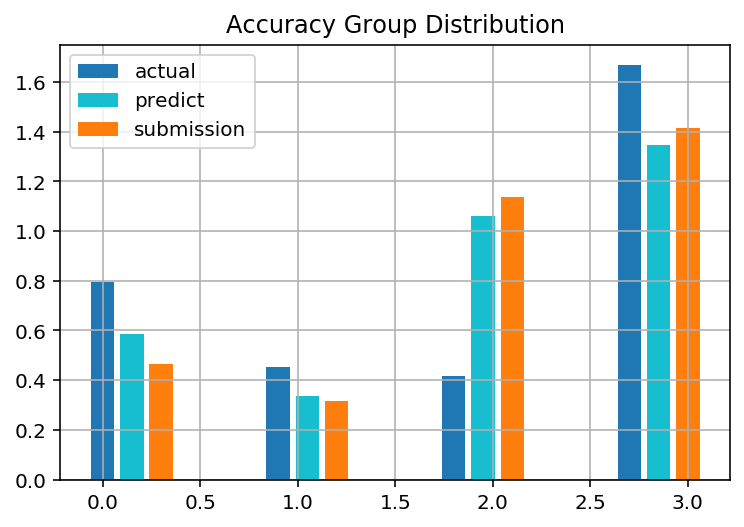

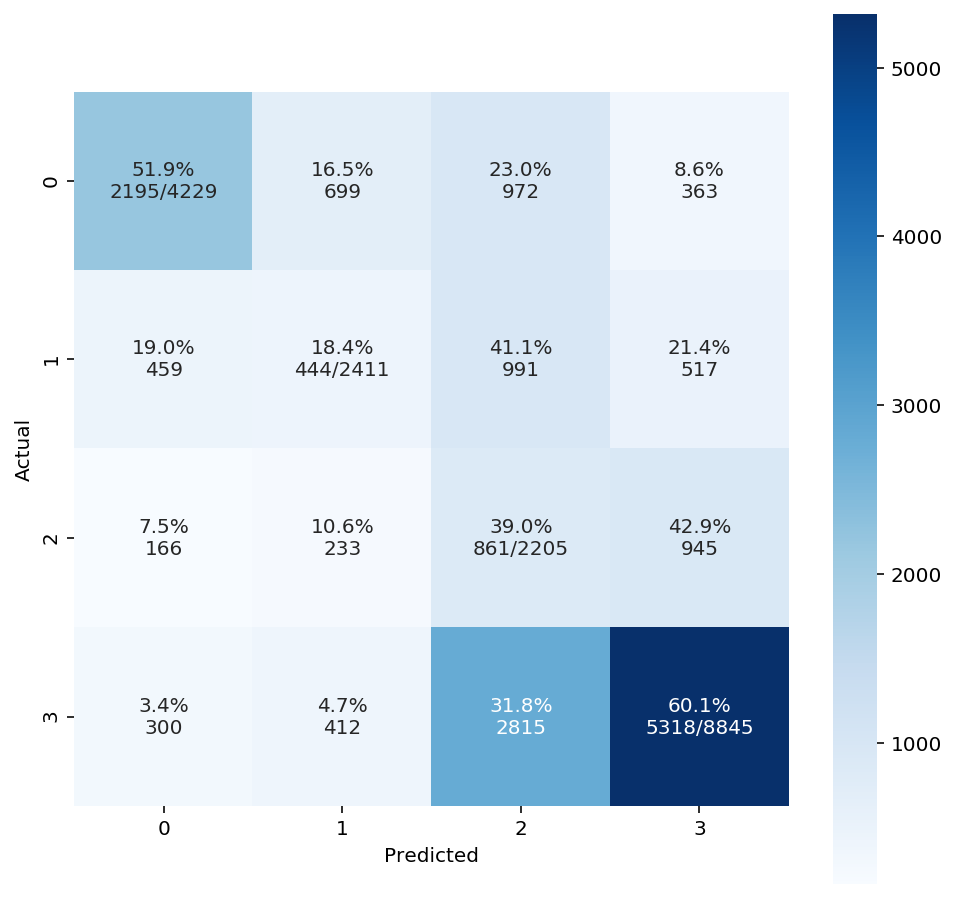

In [40]:
print(f'OOF: {off_score}')
print(f"Truncated OOF QWK: {truncated_score['mean']:.4f}")

def plot_cm(y_true, y_pred, figsize=(8, 8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap=plt.cm.Blues, square=True, annot=annot, fmt='', ax=ax)


plt.title('Accuracy Group Distribution')
reduced_train['accuracy_group'].hist(align='left', rwidth=0.4, normed=True, color='tab:blue', label='actual')
pd.Series(opt_preds).hist(align='mid', rwidth=0.4, normed=True, color='tab:cyan', label='predict')
pd.Series(sub_preds).hist(align='right', rwidth=0.4, normed=True, color='tab:orange', label='submission')
plt.legend()
plt.show()

plot_cm(reduced_train['accuracy_group'], opt_preds)

## Submission

In [41]:
sample_submission['accuracy_group'] = sub_preds
display(sample_submission['accuracy_group'].value_counts(normalize=True).sort_index())

if os.path.exists('/kaggle/input/data-science-bowl-2019/'):
    sample_submission.to_csv('submission.csv', index=False)

0    0.139
1    0.095
2    0.341
3    0.425
Name: accuracy_group, dtype: float64